# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [55]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import time
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.tail(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
pd.set_option('max_rows', None)
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [9]:
feat_info1 = feat_info.copy()
feat_info1['missing_or_unknown'].replace(['[-1,X]', '[XX]', '[-1,XX]'],['[-1,\'X\']', '[\'XX\']', '[-1,\'XX\']'], inplace=True)
feat_info1

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# number of NaNs on each attribute.
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [11]:
# Total number of NaNs
azdias.isnull().sum().sum()

4896838

In [12]:
# making a copy before converting missing codes to NaNs just in case..
azdias_copy1 = azdias.copy()

In [13]:
# Identify missing or unknown data values and convert them to NaNs.
attribute_info = pd.DataFrame(columns=['attribute', 'total_missing'])
for i in range(len(feat_info['attribute'])):
    total_missing = 0
    attribute = feat_info1['attribute'][i]
    missing_code = eval(feat_info1['missing_or_unknown'][i])
#     print("attribute %s, missing code %s" %(attribute,str(missing_code)))
    values_dic = azdias[attribute].value_counts()
#     print(values_dic)
    total_missing = sum([values_dic[i] for i in missing_code if i in values_dic])
#     print(total_missing)
    attribute_info = attribute_info.append({'attribute':attribute, 'total_missing':total_missing}, ignore_index=True)
    if len(missing_code) > 0:
        azdias[attribute].replace(missing_code, np.nan, inplace=True)
    
        
    


In [14]:
#number of missing or unknown values
attribute_info

,attribute,total_missing
0,AGER_TYP,685843
1,ALTERSKATEGORIE_GROB,2881
2,ANREDE_KZ,0
3,CJT_GESAMTTYP,0
4,FINANZ_MINIMALIST,0
5,FINANZ_SPARER,0
6,FINANZ_VORSORGER,0
7,FINANZ_ANLEGER,0
8,FINANZ_UNAUFFAELLIGER,0
9,FINANZ_HAUSBAUER,0


In [15]:
# Number of nulls for each attribute after converting Missing Value Codes to NaNs
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [16]:
# Total number of nulls after converting missing codes to NaNs
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = azdias.isnull().sum()
largest_missing = azdias.isnull().sum().nlargest(20)
percent_md = (largest_missing/azdias.shape[0]) * 100
print(largest_missing)
print(percent_md)

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
KKK               158064
REGIOTYP          158064
W_KEIT_KIND_HH    147988
KBA05_ANTG1       133324
KBA05_ANTG2       133324
KBA05_ANTG3       133324
KBA05_ANTG4       133324
KBA05_GBZ         133324
MOBI_REGIO        133324
PLZ8_ANTG1        116515
PLZ8_ANTG2        116515
PLZ8_ANTG3        116515
PLZ8_ANTG4        116515
PLZ8_BAUMAX       116515
dtype: int64
TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
PLZ8_ANTG1        13.073637
PLZ8_ANTG2        13.073637
PLZ8_ANTG3 

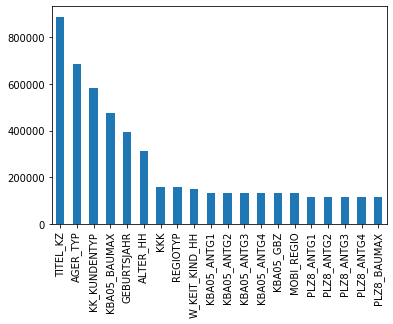

In [18]:
# Investigate patterns in the amount of missing data in each column.
largest_missing.plot(kind='bar')

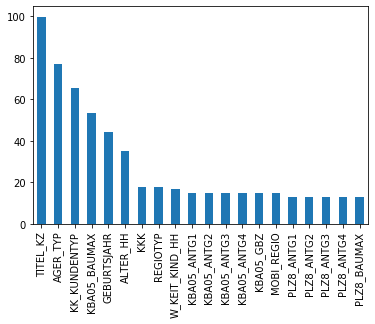

In [19]:
percent_md.plot(kind='bar')

In [20]:
missing_data_f = missing_data.to_frame()
counts = missing_data_f[0].value_counts().to_dict()
for i in list(counts):
    if counts[i] == 1:
        counts.pop(i)

print(counts)

{0: 24, 116515: 7, 4854: 6, 133324: 6, 93148: 4, 73499: 4, 111196: 3, 99352: 3, 93740: 3, 97375: 2, 77792: 2, 158064: 2}


In [21]:
# Assigning each frequent value a color for recognizing patterns.
counts[0] = '\033[31;49m'
counts[116515] = '\033[32;49m'
counts[4854] = '\033[34;49m'
counts[133324] = '\033[35;49m'
counts[93148] = '\033[33;49m'
counts[73499] = '\033[30;44m'
counts[111196] = '\033[30;41m'
counts[99352] = '\033[30;42m'
counts[93740] = '\033[30;45m'
counts[97375] = '\033[30;46m'
counts[77792] = '\033[30;47m'
counts[158064] = '\033[36;49m'


In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Drop columns that have over 30% NaNs.
outliers = percent_md[percent_md >= 30]
azdias.drop(columns=outliers.axes[0], inplace=True)
azdias.shape

(891221, 79)

In [23]:
missing_data_frame = pd.DataFrame(columns=['attribute', 'NaNs'])
missing_data_frame['attribute'] = missing_data.axes[0]
missing_data_frame['NaNs'] = missing_data.values

In [24]:
# Printing colored values
color = ""
for i in range(len(missing_data_frame)):
    attr = missing_data_frame['attribute'][i]
    nan = missing_data_frame['NaNs'][i]
    if nan in counts:
        color = counts[nan]
    else:
        color = '\033[39;49m'
        print(color)
    print (color+'%-25s%-12s' % (attr, nan))


AGER_TYP                 685843      

ALTERSKATEGORIE_GROB     2881        
ANREDE_KZ                0           
CJT_GESAMTTYP            4854        
FINANZ_MINIMALIST        0           
FINANZ_SPARER            0           
FINANZ_VORSORGER         0           
FINANZ_ANLEGER           0           
FINANZ_UNAUFFAELLIGER    0           
FINANZ_HAUSBAUER         0           
FINANZTYP                0           

GEBURTSJAHR              392318      
GFK_URLAUBERTYP          4854        
GREEN_AVANTGARDE         0           
HEALTH_TYP               111196      

LP_LEBENSPHASE_FEIN      97632       

LP_LEBENSPHASE_GROB      94572       
LP_FAMILIE_FEIN          77792       
LP_FAMILIE_GROB          77792       
LP_STATUS_FEIN           4854        
LP_STATUS_GROB           4854        

NATIONALITAET_KZ         108315      

PRAEGENDE_JUGENDJAHRE    108164      
RETOURTYP_BK_S           4854        
SEMIO_SOZ                0           
SEMIO_FAM                0           
SEMIO

#### Discussion 1.1.2: Assess Missing Data in Each Column
 
After looking at the plot and the results of the 20 largest missing values, we can see that attributes that have over 30% NaNs are outlying. So, the columns removed are:
- TITEL_KZ          
- AGER_TYP          
- KK_KUNDENTYP      
- KBA05_BAUMAX      
- GEBURTSJAHR       
- ALTER_HH  

Also, we can see patterns in the above results. For example, FINANZ and SAMIO group all having no missing values.
Here is all matching attributes which are possibly related to each other:
- LP_FAMILIE group which represents family type
- LP_STATUS group which represents social status
- ANZ group which represents the number of adults or academic title holders in household
- GEBAEUDETYP, MIN_GEBAEUDEJAHR, OST_WEST_KZ, WOHNLAGE attributes share building and neighborhood info
- CAMEO group which represents Wealth / Life Stage info in different scales
- KBA05 group represents the number of different family houses types in the microcell
- BALLRAUM, EWDICHTE, INNENSTADT attributes represent different metrics related to households, urban center, and city center
- KKK and REGIOTYP attributes represent region purchasing power and type
- PLZ8 group which contains different info about PLZ8 region
- ARBEIT and RELAT_AB attributes represent the share of unemployment in  community and relative to county

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
# How much data is missing in each row of the dataset?
row_missing_data = azdias.isnull().sum(axis=1)


In [26]:
# Top 20 rows with the highest missing values
row_missing_data.nlargest(20)

643174    49
732775    49
472919    48
11        47
14        47
17        47
24        47
48        47
54        47
69        47
75        47
97        47
99        47
103       47
108       47
112       47
133       47
137       47
144       47
154       47
dtype: int64

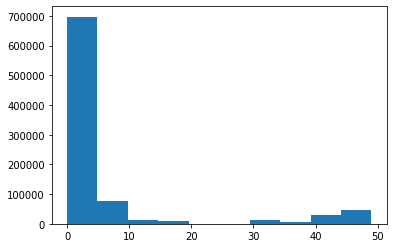

In [27]:
plt.hist(row_missing_data);

### We can see that data is actually splittable since it's is distributed between 0 - 20 and 30 - 50

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# data can be split into two sections over 30 and under 30.
under30_data = azdias[row_missing_data < 30]
over30_data = azdias[row_missing_data >= 30]
print("Number of data with under 30 missing values: %i representing %.2f%%" % (under30_data.shape[0], (under30_data.shape[0]/azdias.shape[0])*100))
print("Number of data with over 30 missing values: %i representing %.2f%%" % (over30_data.shape[0], (over30_data.shape[0]/azdias.shape[0])*100))

Number of data with under 30 missing values: 798061 representing 89.55%
Number of data with over 30 missing values: 93160 representing 10.45%


In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_dist(under30, over30, column):

    plt.figure(figsize=(14,4))   
    ax1 = plt.subplot(121)
    ax1.title.set_text('Over 30 missing values')
    sns.countplot(over30_data[column])

    ax2 = plt.subplot(122)
    ax2.title.set_text('Under 30 missing values')
    sns.countplot(under30_data[column])

    plt.suptitle(column)
    plt.show()
  


In [30]:
# Top 30 rows with the lowest missing data
smallest_30 = missing_data.nsmallest(30)
smallest_30

ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GREEN_AVANTGARDE            0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
ZABEOTYP                    0
ALTERSKATEGORIE_GROB     2881
CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
dtype: int64

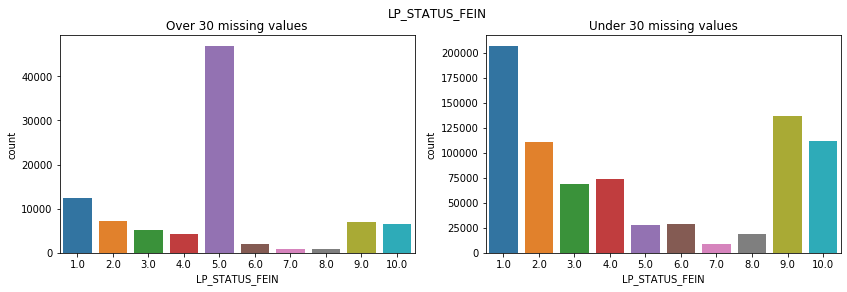

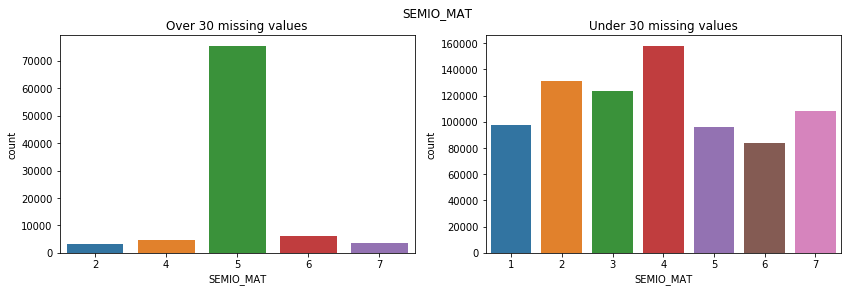

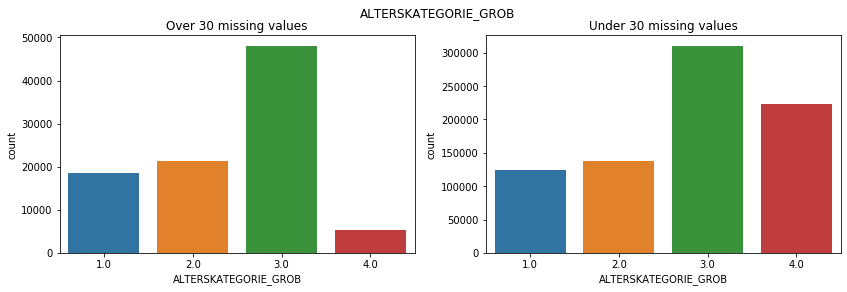

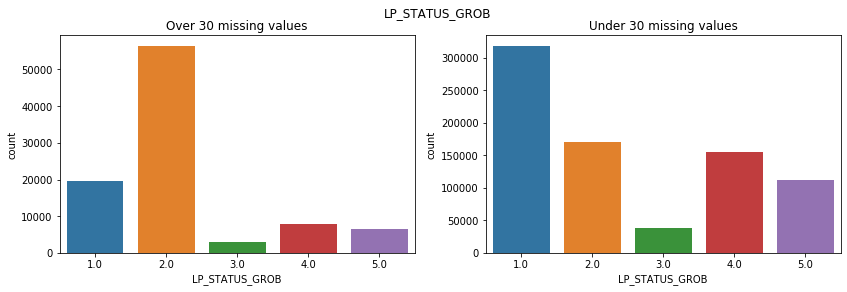

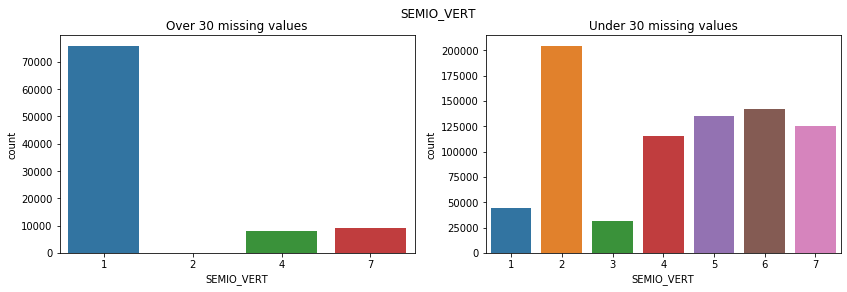

In [31]:
random.seed(0) # for reproducibility
smallest_5 = random.sample(list(smallest_30.axes[0]), 5)
for column in smallest_5:
    compare_dist(under30_data, over30_data, column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

After selecting 5 random column with no or few missing values and plotting them with each subset of the data i.e. over 30 and under 30, we can see that the distribution of values is different between the two groups. Some features in the "over30" group have bias toward particular values in which it could be useful in the other group.  
I think it's important not to change the y axis limit for the "over30" group to preserve the distribution shape.  
Even tough the data with high missing values have some useful information, it only represents 10% of the total data.  
So, going with the other 90% won't have a high impact.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

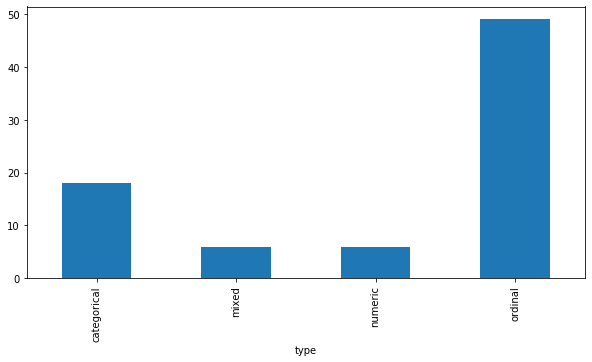

In [32]:
# How many features are there of each data type?
# droping outliers columns
feat_info = feat_info[feat_info['attribute'].isin(outliers.axes[0]) == False]
feat_info.groupby('type')['attribute'].count().plot(kind='bar', figsize=(10,5))
feat_info.type.value_counts()

#### We only need to deal with categorical and mixed variable types. Therefore, 24 features need to be dealt with or removed.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_type_dict = {}
cat_feat = feat_info[feat_info['type'] == 'categorical'].attribute
for attr in cat_feat:
    if under30_data[attr].nunique() == 2:
        if type(under30_data[attr].iloc[0]) == str:
            cat_type_dict[attr] = 'non-numeric binary'
        else:
            cat_type_dict[attr] = 'binary'
    else:
        cat_type_dict[attr] = 'multi-level'

In [34]:
for key in cat_type_dict:
    print("%-18s%s" % (key, cat_type_dict[key]))

ANREDE_KZ         binary
CJT_GESAMTTYP     multi-level
FINANZTYP         multi-level
GFK_URLAUBERTYP   multi-level
GREEN_AVANTGARDE  binary
LP_FAMILIE_FEIN   multi-level
LP_FAMILIE_GROB   multi-level
LP_STATUS_FEIN    multi-level
LP_STATUS_GROB    multi-level
NATIONALITAET_KZ  multi-level
SHOPPER_TYP       multi-level
SOHO_KZ           binary
VERS_TYP          binary
ZABEOTYP          multi-level
GEBAEUDETYP       multi-level
OST_WEST_KZ       non-numeric binary
CAMEO_DEUG_2015   multi-level
CAMEO_DEU_2015    multi-level


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.
# For OST_WEST_KZ, we'll re-encode its values as numbers

under30_data['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

C:\Users\dhm-1\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [36]:
under30_data['OST_WEST_KZ'].value_counts()

1    629520
0    168541
Name: OST_WEST_KZ, dtype: int64

In [37]:
# For multi-level categories, we'll use one-hot-encoding
under30_data = pd.get_dummies(under30_data, columns=[i for i in cat_type_dict if cat_type_dict[i]=='multi-level'])

In [38]:
under30_data.shape

(798061, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

For numerical and ordinal data types, we'll leave them as is.  
For categorical data types, they're divided into 3 different types binary, non-numeric binary, and multi-level.  
Numerical binaries are left as is while non-numerical binaries are re-encoded to numbers.  
We won't drop multi-level categorical data types as they might be useful. Besides that, we've already dropped lots of data.   Therefore, we've applied one-hot encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
gen_decade = {0: (1, 2), 1: (3, 4), 2: (5, 6, 7), 3: (8, 9), 4: (10, 11, 12, 13), 5: (14, 15)}
movement = {0: (1, 3, 5, 8, 10, 12, 14), 1: (2, 4, 6, 7, 9, 11, 13, 15)}

def map_gen(val):
    if not np.isnan(val):
        return list(gen_decade.keys())[list(gen_decade.values()).index([i for i in list(gen_decade.values()) if val in i][0])]
    else:
        return np.nan
    
def map_movement(val):
    if not np.isnan(val):
        return list(movement.keys())[list(movement.values()).index([i for i in list(movement.values()) if val in i][0])]
    else:
        return np.nan
    

In [40]:
under30_data['PRAEGENDE_JUGENDJAHRE_GENERATION'] = under30_data['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
under30_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = under30_data['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [41]:
under30_data['PRAEGENDE_JUGENDJAHRE_GENERATION'].head()

1    5.0
2    5.0
3    3.0
4    3.0
5    1.0
Name: PRAEGENDE_JUGENDJAHRE_GENERATION, dtype: float64

In [42]:
under30_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def map_wealth(val):
    val = float(val)
    if not np.isnan(val):
        return val//10
    else:
        return np.nan
    
def map_life_stage(val):
    val = float(val)
    if not np.isnan(val):
        return val%10
    else:
        return np.nan

In [44]:
under30_data['CAMEO_INTL_2015_WEALTH'] = under30_data['CAMEO_INTL_2015'].apply(map_wealth)
under30_data['CAMEO_INTL_2015_LS'] = under30_data['CAMEO_INTL_2015'].apply(map_life_stage)

In [45]:
under30_data['CAMEO_INTL_2015_WEALTH'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [46]:
under30_data['CAMEO_INTL_2015_LS'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_LS, dtype: float64

In [47]:
# Dropping PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
under30_data.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)

In [48]:
under30_data.shape

(798061, 196)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step, we properly dealt with mixed-type features by dividing them into new features.  
PRAEGENDE_JUGENDJAHRE was divided into generation and mevement, while CAMEO_INTL_2015 was divided into wealth and life style.  
The other mixed-type features have been dropped for the sake of simplicity.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [49]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
pd.set_option('max_columns', None)
under30_data.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LS
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['missing_or_unknown'].replace(['[-1,X]', '[XX]', '[-1,XX]'],['[-1,\'X\']', '[\'XX\']', '[-1,\'XX\']'],inplace=True)
    for i in range(len(feat_info['attribute'])):
        attribute = feat_info['attribute'][i]
        missing_code = eval(feat_info['missing_or_unknown'][i])
        if len(missing_code) > 0:
            df[attribute].replace(missing_code, np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    # Since columns with over 30% missing values might differ in this dataset, we should hardcode them.
    outliers = ['TITEL_KZ',
                'AGER_TYP',
                'KK_KUNDENTYP',
                'KBA05_BAUMAX',
                'GEBURTSJAHR',
                'ALTER_HH']
    df.drop(columns=outliers, inplace=True)
    # For rows we can apply the same procedure without hardcoding since there is no particular important rows
    row_missing_data = df.isnull().sum(axis=1)
    under30_data = df[row_missing_data < 30]
    # select, re-encode, and engineer column values.
    # droping outliers columns
    feat_info = feat_info[feat_info['attribute'].isin(outliers) == False]

    cat_type_dict = {}
    cat_feat = feat_info[feat_info['type'] == 'categorical'].attribute
    for attr in cat_feat:
        if under30_data[attr].nunique() == 2:
            if type(under30_data[attr].iloc[0]) == str:
                cat_type_dict[attr] = 'non-numeric binary'
            else:
                cat_type_dict[attr] = 'binary'
        else:
            cat_type_dict[attr] = 'multi-level'

    under30_data['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    under30_data = pd.get_dummies(under30_data, columns=[i for i in cat_type_dict if cat_type_dict[i]=='multi-level'])

    def map_gen(val):
        if not np.isnan(val):
            return list(gen_decade.keys())[list(gen_decade.values()).index([i for i in list(gen_decade.values()) if val in i][0])]
        else:
            return np.nan

    def map_movement(val):
        if not np.isnan(val):
            return list(movement.keys())[list(movement.values()).index([i for i in list(movement.values()) if val in i][0])]
        else:
            return np.nan

    under30_data['PRAEGENDE_JUGENDJAHRE_GENERATION'] = under30_data['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    under30_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = under30_data['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

    def map_wealth(val):
        val = float(val)
        if not np.isnan(val):
            return val//10
        else:
            return np.nan

    def map_life_stage(val):
        val = float(val)
        if not np.isnan(val):
            return val%10
        else:
            return np.nan

    under30_data['CAMEO_INTL_2015_WEALTH'] = under30_data['CAMEO_INTL_2015'].apply(map_wealth)
    under30_data['CAMEO_INTL_2015_LS'] = under30_data['CAMEO_INTL_2015'].apply(map_life_stage)

    under30_data.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)
    
    # Return the cleaned dataframe.
    return under30_data
    

In [51]:
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [52]:
new_df = clean_data(azdias_test)

In [53]:
# Making sure the function is valid
print(under30_data.shape)
print(new_df.shape)

(798061, 196)
(798061, 196)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [56]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# we'll use SimpleImputer to replace NaNs with proper values.
# The NaNs will be replaced with the most frequent value in their attribute. 

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(under30_data)
under30_data[:] = imp.transform(under30_data)

In [57]:
under30_data.isnull().sum().sum()

0

In [58]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
sc_azdias = scaler.fit_transform(under30_data)

### Discussion 2.1: Apply Feature Scaling

Dealing with the remaining missing values or NaNs, we used an Imputer to replace the missing values with valid numbers.  
I was going to use mean as a strategy for the Imputer, but I thought it might cause some problems since some attributes are integer-based.  
After imputing, the data has been scaled using StrandardScaler to be ready for PCA

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [59]:
# Apply PCA to the data.
pca = PCA()
pca_azdias = pca.fit_transform(sc_azdias)


x= 85 y= 0.8044715719646234


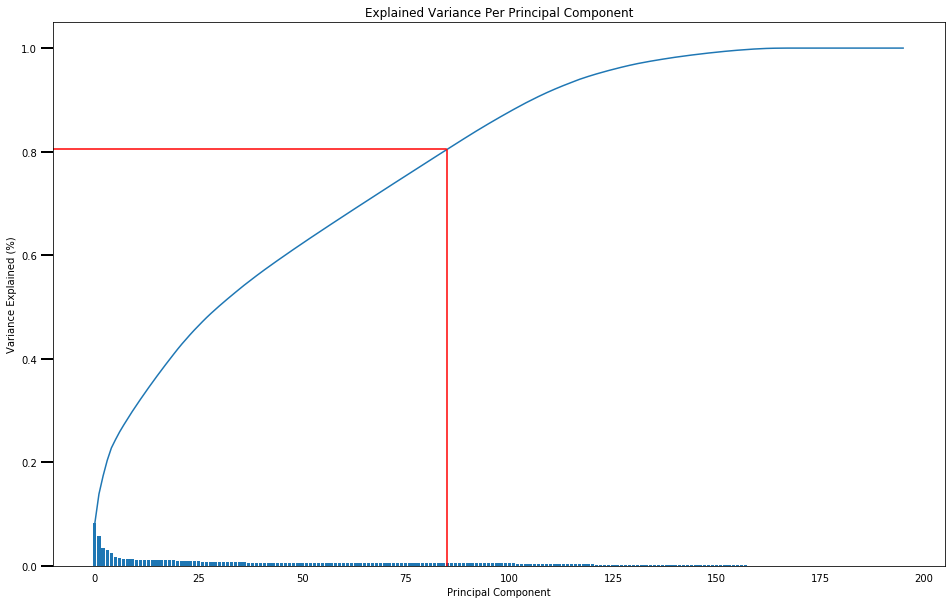

In [60]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
#     ax.axhline(linewidth=2, color='r')
    line = ax.lines[0]
    xvalues = line.get_xdata()
    yvalues = line.get_ydata()
    idy = np.where(yvalues >= 0.8) 
    x = idy[0][0]
    y = yvalues[x]
    print("x=", x, "y=", y)
    ax.axhline(y=y, xmin=0, xmax=(x/xvalues[-3]), color='r')
    ax.axvline(x, 0, 0.764, color='r')
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.
# We'll go with the number of principal components that yields over 80% variance which is 85.
pca = PCA(n_components=85)
pca_azdias = pca.fit_transform(sc_azdias)


### Discussion 2.2: Perform Dimensionality Reduction
 
We applied Principal Component Analysis (PCA) on our data to reduce the number of dimensions.  
Over 80% (0.80447) variance seems good enough which's a result of 85 principal components.  
So, the number of dimensions has been reduced from 196 to 85

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(data, pca, pca_ind, feat_num):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    --------------------------
    data: data used
    pca: PCA object
    pca_ind: principal component number, 0 is the first, 1 is the second, and so on...
    feat_num: number of features to be shown
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(data.keys()))
    components.index = dimensions

    # PCA explained variance
    top_feat = abs(components.iloc[pca_ind]).nlargest(feat_num).axes[0]
    top_feat_val = components[top_feat].iloc[pca_ind].sort_values(ascending=False)
    # plot results
    top_feat_val.plot(kind='bar', 
                      figsize=(14, 8), 
                      title="Principal component %s with top %s weighted features" % (str(pca_ind+1), str(feat_num)))
    plt.show()
    return top_feat_val


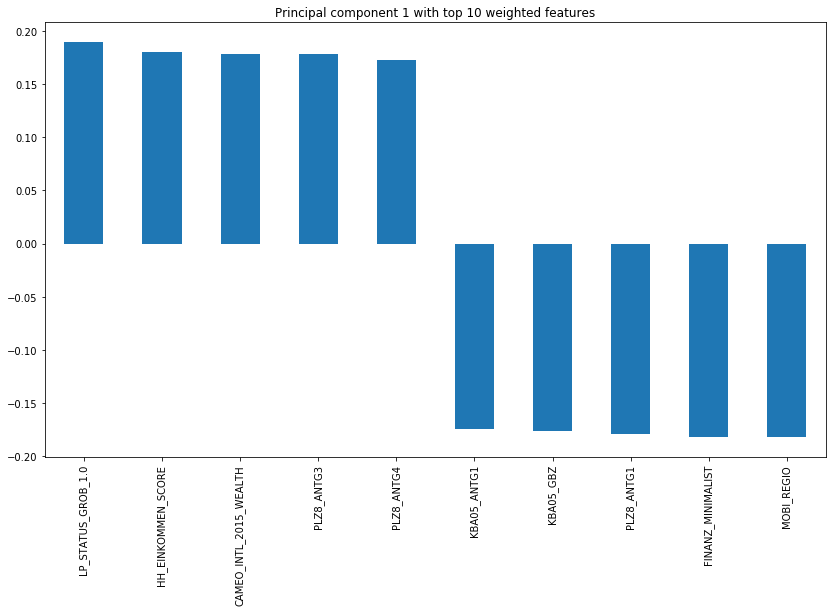

LP_STATUS_GROB_1.0        0.1897
HH_EINKOMMEN_SCORE        0.1800
CAMEO_INTL_2015_WEALTH    0.1784
PLZ8_ANTG3                0.1783
PLZ8_ANTG4                0.1728
KBA05_ANTG1              -0.1749
KBA05_GBZ                -0.1761
PLZ8_ANTG1               -0.1795
FINANZ_MINIMALIST        -0.1822
MOBI_REGIO               -0.1825
Name: Dimension 1, dtype: float64


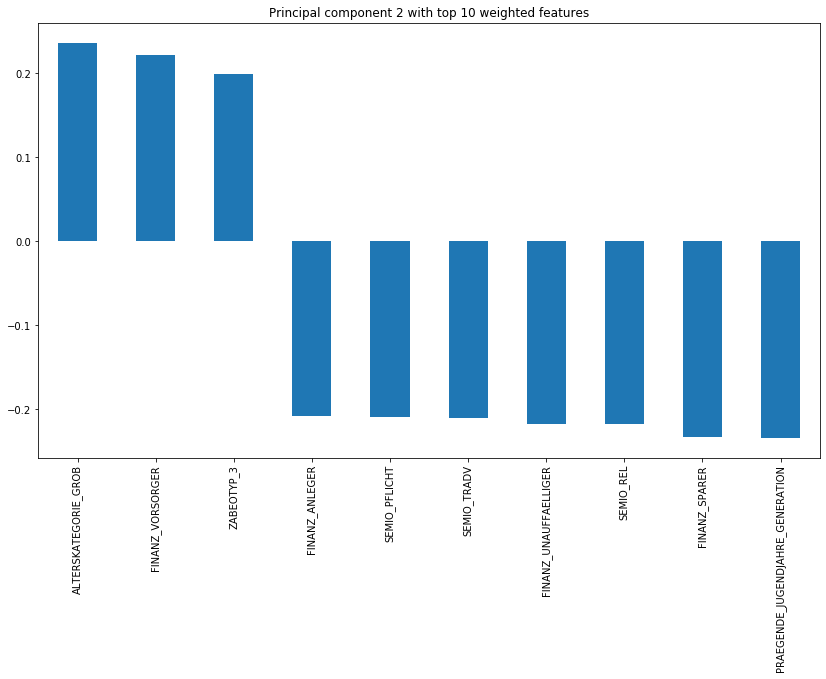

ALTERSKATEGORIE_GROB                0.2364
FINANZ_VORSORGER                    0.2223
ZABEOTYP_3                          0.1995
FINANZ_ANLEGER                     -0.2074
SEMIO_PFLICHT                      -0.2096
SEMIO_TRADV                        -0.2097
FINANZ_UNAUFFAELLIGER              -0.2169
SEMIO_REL                          -0.2179
FINANZ_SPARER                      -0.2328
PRAEGENDE_JUGENDJAHRE_GENERATION   -0.2341
Name: Dimension 2, dtype: float64


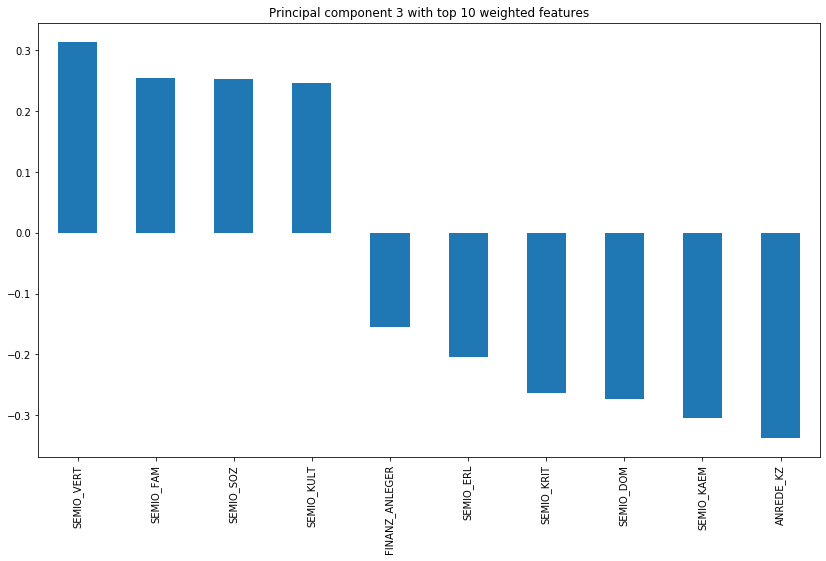

SEMIO_VERT        0.3134
SEMIO_FAM         0.2544
SEMIO_SOZ         0.2537
SEMIO_KULT        0.2462
FINANZ_ANLEGER   -0.1555
SEMIO_ERL        -0.2052
SEMIO_KRIT       -0.2645
SEMIO_DOM        -0.2729
SEMIO_KAEM       -0.3051
ANREDE_KZ        -0.3372
Name: Dimension 3, dtype: float64


In [63]:
for i in range(3):
    results = pca_results(under30_data, pca, i, 10)
    print(results)


### Discussion 2.3: Interpret Principal Components

### For the first principal component:
#### Positively correlated features:
- LP_STATUS_GROB_1.0: low-income earners (highest weight)
- HH_EINKOMMEN_SCORE: Estimated household net income
- CAMEO_INTL_2015_WEALTH: german CAMEO: Wealth (mixed type attribute we engineered)
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region 
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region    

For these features, it makes sense that they are related especially the first 3 features.  

#### Negatively correlated features:
- KBA05_ANTG1: Number of 1-2 family houses in the microcell
- KBA05_GBZ: Number of buildings in the microcell
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- FINANZ_MINIMALIST: Financial typology (low financial interest)
- MOBI_REGIO: Movement patterns in region (highest weight)  

We can see that the first 3 features are actually related.  

### For the second principal component:
#### Positively correlated features:
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (highest weight)
- FINANZ_VORSORGER: Financial typology (being financially prepared)
- ZABEOTYP_3: Energy consumption typology (fair supplied)  

Here we can see some personality traits.


#### Negatively correlated features:
- FINANZ_ANLEGER: Financial typology (investor) 
- SEMIO_PFLICHT: Personality typology (dutiful)
- SEMIO_TRADV: Personality typology (tradional-minded)
- FINANZ_UNAUFFAELLIGER: Financial typology (inconspicuous)
- SEMIO_REL: Personality typology (religious)
- FINANZ_SPARER: Financial typology (money-saver)
- PRAEGENDE_JUGENDJAHRE_GENERATION: Person's generation (mixed type attribute we engineered) (highest weight)  

Also here, most attributes are peronality-based.

### For the third principal component:
#### Positively correlated features:
- SEMIO_VERT: Personality typology (dreamful) (highest weight)
- SEMIO_FAM: Personality typology (family-minded)
- SEMIO_SOZ: Personality typology (socially-minded)
- SEMIO_KULT: Personality typology (cultural-minded)  

All the postively correlated attributes are peronality-based.


#### Negatively correlated features:
- FINANZ_ANLEGER: Financial typology (investor)
- SEMIO_ERL: Personality typology (event-oriented)
- SEMIO_KRIT: Personality typology (critical-minded)
- SEMIO_DOM: Personality typology (dominant-minded)
- SEMIO_KAEM: Personality typology (combative attitude)
- ANREDE_KZ: Gender (highest weight)  

Same in here as well.

### Conclusion:  
- First principal component represents mostly financial features with financial attributes (positive) against region attributes (negative). Inverse proportionality between highest weights low-income earners vs. Movement patterns in region.
- Second principal component represents mostly personality features with mixed attributes (positive) against Personality attributes (negative). Inverse proportionality between highest weights Estimated age based on given name analysis vs. Person's generation.  
- Third principal component represents mostly personality features with personality attributes (positive) against personality attributes (negative). Inverse proportionality between highest weights Personality typology (dreamful) vs. Gender.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
# Over a number of different cluster counts...
scores = []
clusters = []
for i in range(1, 16):
    start=time.time()
    # instantiate KMeans object with i number of clusters
    kmeans = KMeans(i, n_jobs=-1)
    # fit the model to our data
    model = kmeans.fit(pca_azdias)
    # Obtain the score
    score = abs(model.score(pca_azdias))
    scores.append(score)
    clusters.append(i)
    end = time.time()
    elapsed_time = end - start
    print("For %i clusters, score= %.0f" % (i, score))
    print("Elapsed time:", elapsed_time)
    
    

For 1 clusters, score= 124475855
Elapsed time: 21.68499255180359
For 2 clusters, score= 114703637
Elapsed time: 44.67552733421326
For 3 clusters, score= 110249921
Elapsed time: 51.01338028907776
For 4 clusters, score= 107259198
Elapsed time: 66.62672781944275
For 5 clusters, score= 104796370
Elapsed time: 89.22735786437988
For 6 clusters, score= 103287233
Elapsed time: 103.35328936576843
For 7 clusters, score= 102015689
Elapsed time: 121.72442841529846
For 8 clusters, score= 100551993
Elapsed time: 140.3950629234314
For 9 clusters, score= 99507722
Elapsed time: 131.59841680526733
For 10 clusters, score= 98974623
Elapsed time: 144.2403528690338
For 11 clusters, score= 98153565
Elapsed time: 173.3021399974823
For 12 clusters, score= 96796736
Elapsed time: 164.7387797832489
For 13 clusters, score= 95968045
Elapsed time: 219.02519154548645
For 14 clusters, score= 95624889
Elapsed time: 212.8189356327057
For 15 clusters, score= 94917301
Elapsed time: 223.84452438354492


In [65]:
SSE_dif = []
for i in range(len(scores)):
    if i+1 >= len(scores):
        break
    dif = int(abs(scores[i+1] - scores[i]))
    print(f'score difference between {i+1} clusters and {i+2} clusters is {dif:,}')


score difference between 1 clusters and 2 clusters is 9,772,217
score difference between 2 clusters and 3 clusters is 4,453,715
score difference between 3 clusters and 4 clusters is 2,990,723
score difference between 4 clusters and 5 clusters is 2,462,827
score difference between 5 clusters and 6 clusters is 1,509,136
score difference between 6 clusters and 7 clusters is 1,271,543
score difference between 7 clusters and 8 clusters is 1,463,696
score difference between 8 clusters and 9 clusters is 1,044,270
score difference between 9 clusters and 10 clusters is 533,099
score difference between 10 clusters and 11 clusters is 821,057
score difference between 11 clusters and 12 clusters is 1,356,829
score difference between 12 clusters and 13 clusters is 828,691
score difference between 13 clusters and 14 clusters is 343,155
score difference between 14 clusters and 15 clusters is 707,587


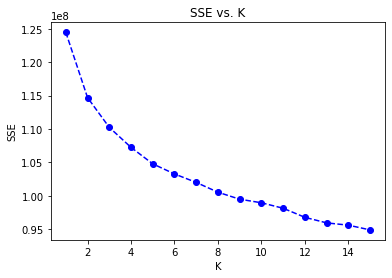

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

### It's unclear in the above plot and in score differences since there is no major drop in score followed by consistent values. Therefore, let's try number of clusters from 16 to 30

In [67]:
scores_1 = []
clusters_1 = []
for i in range(16, 31):
    start=time.time()
    # instantiate KMeans object with i number of clusters
    kmeans = KMeans(i, n_jobs=-1)
    # fit the model to our data
    model = kmeans.fit(pca_azdias)
    # Obtain the score
    score = abs(model.score(pca_azdias))
    scores_1.append(score)
    clusters_1.append(i)
    end = time.time()
    elapsed_time = end - start
    print("For %i clusters, score= %.0f" % (i, score))
    print("Elapsed time:", elapsed_time)

For 16 clusters, score= 94013134
Elapsed time: 219.13526010513306
For 17 clusters, score= 93510489
Elapsed time: 253.8452503681183
For 18 clusters, score= 92965112
Elapsed time: 256.96069860458374
For 19 clusters, score= 92457328
Elapsed time: 282.32905077934265
For 20 clusters, score= 91854002
Elapsed time: 263.5992126464844
For 21 clusters, score= 91309276
Elapsed time: 297.6081745624542
For 22 clusters, score= 90676984
Elapsed time: 304.502867937088
For 23 clusters, score= 90267249
Elapsed time: 330.8014988899231
For 24 clusters, score= 90219270
Elapsed time: 288.83749198913574
For 25 clusters, score= 89266430
Elapsed time: 314.1017920970917
For 26 clusters, score= 88799357
Elapsed time: 378.0051734447479
For 27 clusters, score= 88925606
Elapsed time: 411.70325899124146
For 28 clusters, score= 88197125
Elapsed time: 384.79744720458984
For 29 clusters, score= 87626286
Elapsed time: 359.94133043289185
For 30 clusters, score= 87443876
Elapsed time: 397.40272426605225


In [70]:

for i in range(len(scores_1)):
    if i+1 >= len(scores_1):
        break
    dif = int(abs(scores_1[i+1] - scores_1[i]))
    print(f'score difference between {i+16} clusters and {i+17} clusters is {dif:,}')

score difference between 16 clusters and 17 clusters is 502,645
score difference between 17 clusters and 18 clusters is 545,377
score difference between 18 clusters and 19 clusters is 507,783
score difference between 19 clusters and 20 clusters is 603,326
score difference between 20 clusters and 21 clusters is 544,725
score difference between 21 clusters and 22 clusters is 632,292
score difference between 22 clusters and 23 clusters is 409,735
score difference between 23 clusters and 24 clusters is 47,978
score difference between 24 clusters and 25 clusters is 952,840
score difference between 25 clusters and 26 clusters is 467,072
score difference between 26 clusters and 27 clusters is 126,248
score difference between 27 clusters and 28 clusters is 728,481
score difference between 28 clusters and 29 clusters is 570,838
score difference between 29 clusters and 30 clusters is 182,410


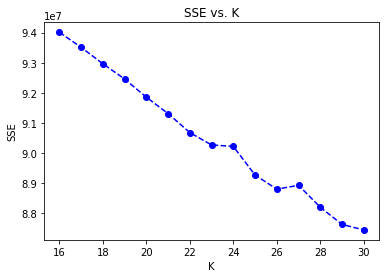

In [69]:
plt.plot(clusters_1, scores_1, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [74]:
all_scores = scores + scores_1
all_clusters = range(1, 31)

In [75]:
for i in range(len(all_scores)):
    if i+1 >= len(all_scores):
        break
    dif = int(abs(all_scores[i+1] - all_scores[i]))
    print(f'score difference between {i+1} clusters and {i+2} clusters is {dif:,}')

score difference between 1 clusters and 2 clusters is 9,772,217
score difference between 2 clusters and 3 clusters is 4,453,715
score difference between 3 clusters and 4 clusters is 2,990,723
score difference between 4 clusters and 5 clusters is 2,462,827
score difference between 5 clusters and 6 clusters is 1,509,136
score difference between 6 clusters and 7 clusters is 1,271,543
score difference between 7 clusters and 8 clusters is 1,463,696
score difference between 8 clusters and 9 clusters is 1,044,270
score difference between 9 clusters and 10 clusters is 533,099
score difference between 10 clusters and 11 clusters is 821,057
score difference between 11 clusters and 12 clusters is 1,356,829
score difference between 12 clusters and 13 clusters is 828,691
score difference between 13 clusters and 14 clusters is 343,155
score difference between 14 clusters and 15 clusters is 707,587
score difference between 15 clusters and 16 clusters is 904,167
score difference between 16 clusters an

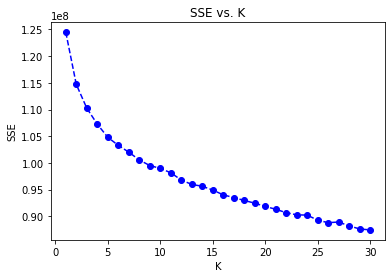

In [76]:
plt.plot(all_clusters, all_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

#### The above results of clusters from 16 to 30 didn't add much information that I was expecting. However, 9-10 clusters appear to be good values for our model.

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(9, n_jobs=-1)
model = kmeans.fit(pca_azdias)
preds = model.predict(pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

After getting the scores, scores differences, and plots for clusters from 1 to 30. I've decided to go with 9 clusters as it appears to be a good value even though it wasn't really obvious.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [81]:
customers.shape

(191652, 85)

In [82]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [84]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


C:\Users\dhm-1\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [86]:
customers_clean.shape

(141725, 195)

In [87]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LS
0,4.0,1,5,1,5,1,2,2,1,1.0,20.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,13.0,3.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

##### customers data has 1 column less than general population data (195 to 196)

In [91]:
new_df.columns.difference(customers_clean.columns)

Index(['GEBAEUDETYP_5.0'], dtype='object')

##### It seems that customers data doesn't have a value of 5 in the GEBAEUDETYP column

In [102]:
geb_loc = customers_clean.columns.get_loc("GEBAEUDETYP_4.0")

customers_clean.insert(geb_loc+1, "GEBAEUDETYP_5.0", 0)

In [103]:
customers_clean.shape

(141725, 196)

In [104]:
# impute and scale
customers_imp = imp.transform(customers_clean)
customers_sc = scaler.transform(customers_imp)

In [107]:
customers_sc.shape

(141725, 196)

In [108]:
# PCA
customers_pca = pca.transform(customers_sc)

In [109]:
customers_pca.shape

(141725, 85)

In [110]:
# get predections
customers_preds = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [125]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_count = pd.Series(preds)
sorted_pop = population_count.value_counts().sort_index()

In [126]:
customers_count = pd.Series(customers_preds)
sorted_cust = customers_count.value_counts().sort_index()

In [141]:
comp_table = pd.DataFrame()
comp_table['cluster'] = range(9)
comp_table['population'] = sorted_pop
comp_table['customers'] = sorted_cust
comp_table['population_prop'] = sorted_pop/sorted_pop.sum()
comp_table['customers_prop'] = sorted_cust/sorted_cust.sum()
comp_table['prop_difference'] = comp_table['population_prop'] - comp_table['customers_prop']

In [142]:
comp_table

,cluster,population,customers,population_prop,customers_prop,prop_difference
0,0,108018,52964,0.135351,0.373710,-0.238359
1,1,80184,16998,0.100474,0.119936,-0.019463
2,2,102388,14299,0.128296,0.100893,0.027403
3,3,73327,1213,0.091881,0.008559,0.083323
4,4,105667,15815,0.132405,0.111589,0.020815
5,5,35054,15245,0.043924,0.107567,-0.063644
6,6,101208,1491,0.126817,0.010520,0.116297
7,7,84008,2000,0.105265,0.014112,0.091153
8,8,108207,21700,0.135587,0.153113,-0.017526


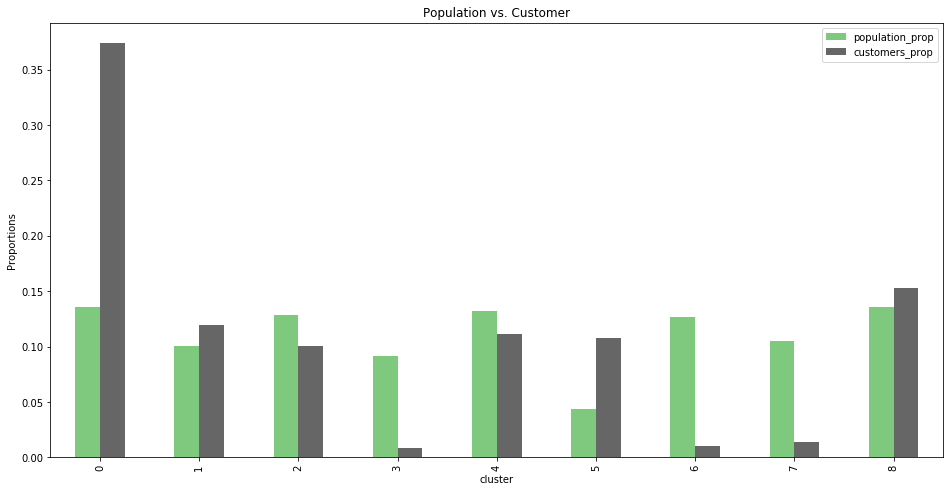

In [140]:
comp_table.plot(x='cluster', y=['population_prop', 'customers_prop'], kind='bar', figsize=(16, 8), colormap='Accent')
plt.title('Population vs. Customer')
plt.ylabel('Proportions')
plt.show()

##### The above results show that cluster 0 is overrepresented in the customer data comapered to the general population. On the other hand, cluster 6 is underrepresented.
##### But in general, clusters 0, 1,5, and 8 over-representing customers despite the differences in propotions. However, clusters 2, 3, 4, 6, and 7 under-represents customers. 

In [194]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# 5 most weighted principal components for cluster 0 (overrepresented)
cluster0 = model.cluster_centers_[0]
cluster0_frame = pd.DataFrame(cluster0, columns=['weights'])
c0_largest = abs(cluster0_frame['weights']).nlargest(5).axes[0]
cluster0_frame.iloc[c0_largest]

,weights
0,-4.567004
3,2.566140
4,-2.094387
2,1.175571
6,-0.999969


##### Principal component 0 and Principal component 3 are the most weighted in cluster 0 where both are inversely proportional to each other.
##### Let's visualize both of them

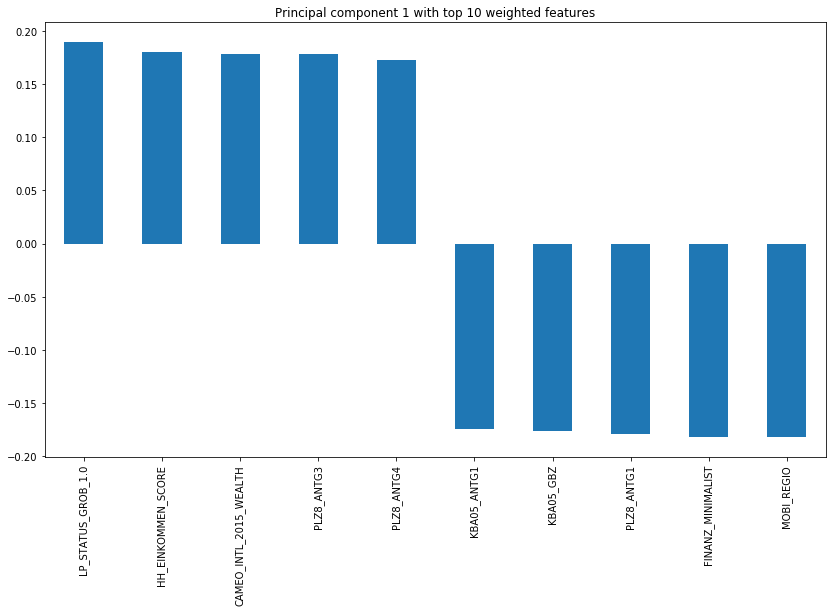

LP_STATUS_GROB_1.0        0.1897
HH_EINKOMMEN_SCORE        0.1800
CAMEO_INTL_2015_WEALTH    0.1784
PLZ8_ANTG3                0.1783
PLZ8_ANTG4                0.1728
KBA05_ANTG1              -0.1749
KBA05_GBZ                -0.1761
PLZ8_ANTG1               -0.1795
FINANZ_MINIMALIST        -0.1822
MOBI_REGIO               -0.1825
Name: Dimension 1, dtype: float64

In [196]:
# Principal component 0
pca_results(under30_data, pca, 0, 10)

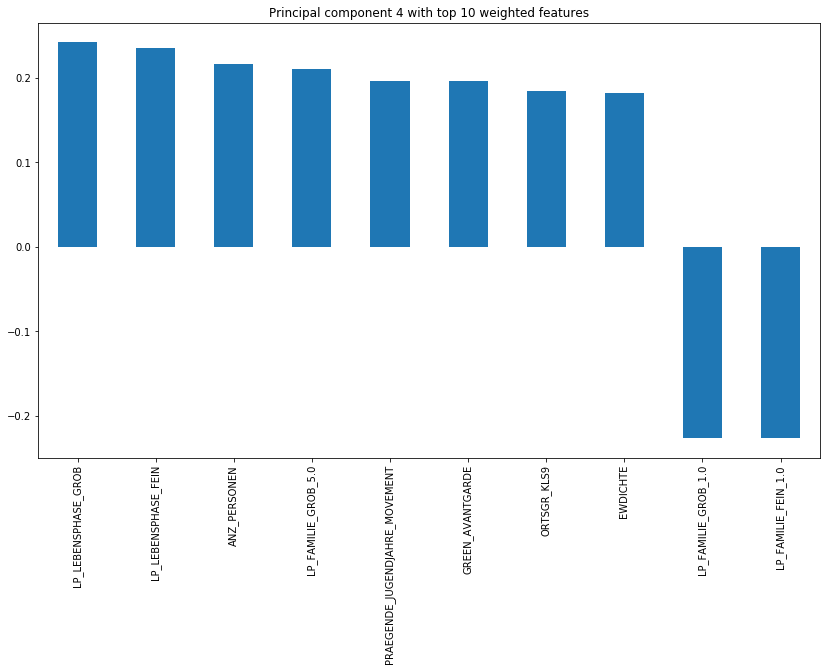

LP_LEBENSPHASE_GROB               0.2418
LP_LEBENSPHASE_FEIN               0.2356
ANZ_PERSONEN                      0.2158
LP_FAMILIE_GROB_5.0               0.2104
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.1965
GREEN_AVANTGARDE                  0.1965
ORTSGR_KLS9                       0.1842
EWDICHTE                          0.1822
LP_FAMILIE_GROB_1.0              -0.2262
LP_FAMILIE_FEIN_1.0              -0.2262
Name: Dimension 4, dtype: float64

In [197]:
# Principal component 3
pca_results(under30_data, pca, 3, 10)

In [206]:
c0 = scaler.inverse_transform(pca.inverse_transform(cluster0))
c0 = pd.Series(c0)
c0.index = customers_clean.columns
c0

ALTERSKATEGORIE_GROB                   3.153896
ANREDE_KZ                              1.476827
FINANZ_MINIMALIST                      4.493226
FINANZ_SPARER                          1.903406
FINANZ_VORSORGER                       3.928983
FINANZ_ANLEGER                         2.028400
FINANZ_UNAUFFAELLIGER                  2.386466
FINANZ_HAUSBAUER                       1.929964
GREEN_AVANTGARDE                       1.008034
HEALTH_TYP                             2.110350
LP_LEBENSPHASE_FEIN                   25.148921
LP_LEBENSPHASE_GROB                    7.303907
RETOURTYP_BK_S                         3.547895
SEMIO_SOZ                              4.186415
SEMIO_FAM                              3.697571
SEMIO_REL                              3.316539
SEMIO_MAT                              3.405846
SEMIO_VERT                             4.769541
SEMIO_LUST                             4.929663
SEMIO_ERL                              4.902004
SEMIO_KULT                             3

In [198]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# 5 most weighted principal components for cluster 6 (underrepresented)
cluster6 = model.cluster_centers_[6]
cluster6_frame = pd.DataFrame(cluster6, columns=['weights'])
c6_largest = abs(cluster6_frame['weights']).nlargest(5).axes[0]
cluster6_frame.iloc[c6_largest]


,weights
0,4.770266
2,-2.340369
1,-2.282165
3,0.851042
10,0.478741


##### Principal component 0 and Principal component 2 are the most weighted in cluster 6 where both are inversely proportional to each other.
##### Let's visualize both of them

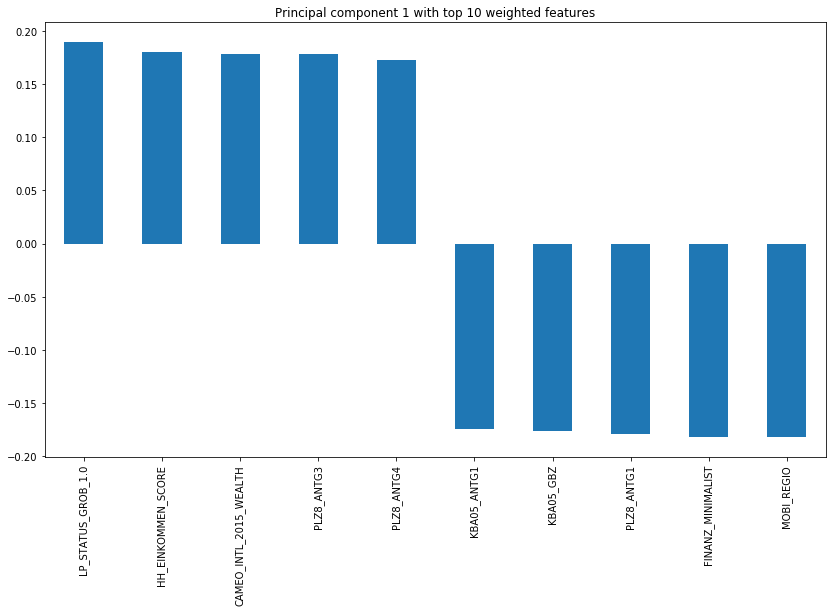

LP_STATUS_GROB_1.0        0.1897
HH_EINKOMMEN_SCORE        0.1800
CAMEO_INTL_2015_WEALTH    0.1784
PLZ8_ANTG3                0.1783
PLZ8_ANTG4                0.1728
KBA05_ANTG1              -0.1749
KBA05_GBZ                -0.1761
PLZ8_ANTG1               -0.1795
FINANZ_MINIMALIST        -0.1822
MOBI_REGIO               -0.1825
Name: Dimension 1, dtype: float64

In [199]:
# Principal component 0
pca_results(under30_data, pca, 0, 10)

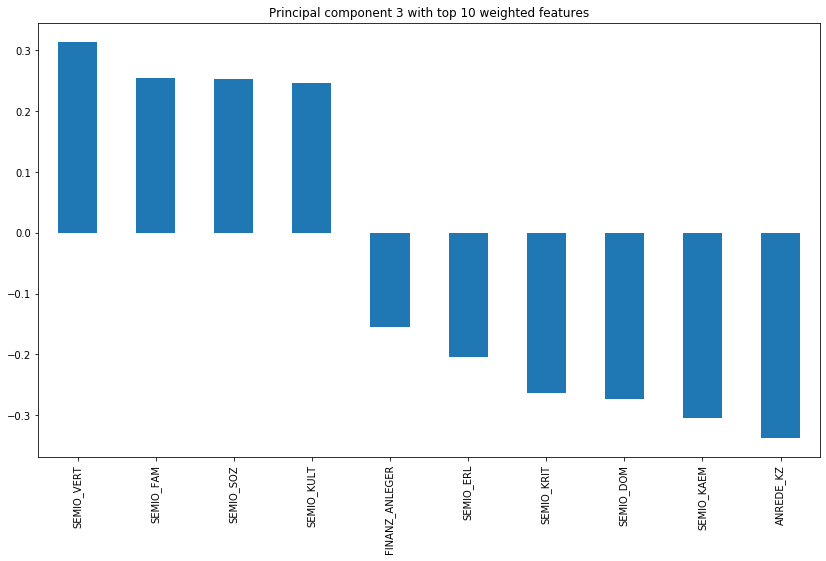

SEMIO_VERT        0.3134
SEMIO_FAM         0.2544
SEMIO_SOZ         0.2537
SEMIO_KULT        0.2462
FINANZ_ANLEGER   -0.1555
SEMIO_ERL        -0.2052
SEMIO_KRIT       -0.2645
SEMIO_DOM        -0.2729
SEMIO_KAEM       -0.3051
ANREDE_KZ        -0.3372
Name: Dimension 3, dtype: float64

In [200]:
# Principal component 2
pca_results(under30_data, pca, 2, 10)

In [207]:
c6 = scaler.inverse_transform(pca.inverse_transform(cluster6))
c6 = pd.Series(c6)
c6.index = customers_clean.columns
c6

ALTERSKATEGORIE_GROB                   1.810446
ANREDE_KZ                              1.983429
FINANZ_MINIMALIST                      1.135551
FINANZ_SPARER                          4.421472
FINANZ_VORSORGER                       2.236274
FINANZ_ANLEGER                         4.338789
FINANZ_UNAUFFAELLIGER                  3.809764
FINANZ_HAUSBAUER                       4.279960
GREEN_AVANTGARDE                       0.041290
HEALTH_TYP                             2.351903
LP_LEBENSPHASE_FEIN                    8.699525
LP_LEBENSPHASE_GROB                    3.157316
RETOURTYP_BK_S                         2.566154
SEMIO_SOZ                              3.240890
SEMIO_FAM                              3.893991
SEMIO_REL                              5.289588
SEMIO_MAT                              4.656663
SEMIO_VERT                             2.292113
SEMIO_LUST                             3.206647
SEMIO_ERL                              4.396360
SEMIO_KULT                             4

In [202]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

### Discussion 3.3: Compare Customer Data to Demographics Data

> There might be some confusion in the PCA numbering between the graphs and comments. However, when it says Principal component 1, it means that it's the first principal component. 

### Results:

After comparing between customers and general population propotions in each cluster, we found that cluster 0 is overrepresented while cluster 6 is underrepresented in the customer data comapered to the general population.  

#### Cluster 0 (where customers are overrepresented):
For cluster 0, principal component 0 and 3 are the most weighted where PC 0 being negative and PC 3 being positive (inverse to each other). 

PCA |weights
---|-------
0	|-4.567004
3	|2.566140  
      
    
##### Principal component 0:

Positively correlated features with values after inverse transformation:  
- LP_STATUS_GROB_1.0: low-income earners (highest weight) | 0
- HH_EINKOMMEN_SCORE: Estimated household net income | 2 (very high income)
- CAMEO_INTL_2015_WEALTH: german CAMEO: Wealth (mixed type attribute we engineered) | 2 (Prosperous Households)
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region | 1 (lower share of 6-10 family homes)  
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region | 0 (no 10+ family homes)

Negatively correlated features with values after inverse transformation:   
- KBA05_ANTG1: Number of 1-2 family houses in the microcell | 3 (high share of 1-2 family homes)  
- KBA05_GBZ: Number of buildings in the microcell | 4 (17-22 buildings) 
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region | 3 (high share of 1-2 family homes) 
- FINANZ_MINIMALIST: Financial typology (low financial interest) | 5 (very low)
- MOBI_REGIO: Movement patterns in region (highest weight) | 4 (low movement)

    
##### Principal component 3:    

Positively correlated features with values after inverse transformation:
- LP_LEBENSPHASE_GROB: Life stage, rough scale | 7 (single low-income and average earner families)
- LP_LEBENSPHASE_FEIN: Life stage, fine scale 25 (average earner families)
- ANZ_PERSONEN: Number of adults in household | 2
- LP_FAMILIE_GROB_5.0: Family type, rough scale (multiperson household) | 0
- PRAEGENDE_JUGENDJAHRE_MOVEMENT: 1 (Mainstream)
- GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth | 1 (member of green avantgarde)
- ORTSGR_KLS9: Size of community | 5 (20,001 to  50,000 inhabitants)
- EWDICHTE: Density of households per square kilometer | 4 (150 - 319 households per km^2)

Negatively correlated features with values after inverse transformation:  
- LP_FAMILIE_GROB_1.0: Family type, rough scale (single) | 0
- LP_FAMILIE_FEIN_1.0: Family type, fine scale (single) | 0
    
#### Cluster 6 (where customers are underrepresented):
For cluster 6, principal component 0 and 2 are the most weighted where PC 0 being positive and PC 3 being negative (inverse to each other). 

PCA|weights
---|---
0|4.770266
2|-2.340369
   
    
##### Principal component 0:

Positively correlated features with values after inverse transformation:  
- LP_STATUS_GROB_1.0: low-income earners (highest weight) | 1
- HH_EINKOMMEN_SCORE: Estimated household net income | 6 (very low income)
- CAMEO_INTL_2015_WEALTH: german CAMEO: Wealth (mixed type attribute we engineered) | 4 (Less Affluent Households)
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region | 2 (average share of 6-10 family homes)  
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region | 1  (lower share of 10+ family homes)

Negatively correlated features with values after inverse transformation:  
- KBA05_ANTG1: Number of 1-2 family houses in the microcell | 1 (lower share of 1-2 family homes)  
- KBA05_GBZ: Number of buildings in the microcell | 2 (3-4 buildings) 
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region | 2 (average share of 1-2 family homes) 
- FINANZ_MINIMALIST: Financial typology (low financial interest) | 1 (very high)
- MOBI_REGIO: Movement patterns in region (highest weight) | 2 (high movement) 

    
##### Principal component 2:    

Positively correlated features with values after inverse transformation:  
- SEMIO_VERT: Personality typology (dreamful) | 2 (very high affinity)
- SEMIO_FAM: Personality typology (family-minded) |	4 (average affinity)
- SEMIO_SOZ: Personality typology (socially-minded) | 3 (high affinity)
- SEMIO_KULT: Personality typology (cultural-minded) | 4 (average affinity)

Negatively correlated features with values after inverse transformation:  
- FINANZ_ANLEGER: Financial typology (investor) | 4 (low)
- SEMIO_ERL: Personality typology (event-oriented) | 4 (average affinity)
- SEMIO_KRIT: Personality typology (critical-minded) | 5 (low affinity)
- SEMIO_DOM: Personality typology (dominant-minded) | 6 (very low affinity)
- SEMIO_KAEM: Personality typology (combative attitude) | 6 (very low affinity)
- ANREDE_KZ: Gender	| 2 (female)

### Conclusion:

After looking at the results, we can see that cluster 0 represents the target audience for the company, while cluster 6 appears to represent non-target audience.  
From the results above, it looks like cluster 0 which represents the target audience for the company groups people who are wealthy, with low movement, live in 1-2 family houses. While cluster 6 which represents the non-target audience for the company clusters people who are with low income, high movement patterns, who live in with high number of family members.  

In general, this is a basic analysis and is not thorough enough to provide a highly accurate interpretation of the results.  
But, it's enough to explain the general idea and purpose of the project.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.